In [2]:
import hypernetx as hnx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import warnings 
warnings.simplefilter('ignore')

The `hypernetx` library can construct hypergraphs from many python data structures (lists, dictionaries, etc.)

Here I focus on what should matter in the mathematical approach, i.e. the **incidence matrices**.

I'll think of Gatien's [Thermodynamic Ciruits 4](https://arxiv.org/abs/2412.15028) paper and try to implement a piece of the circuit in Fig 1.


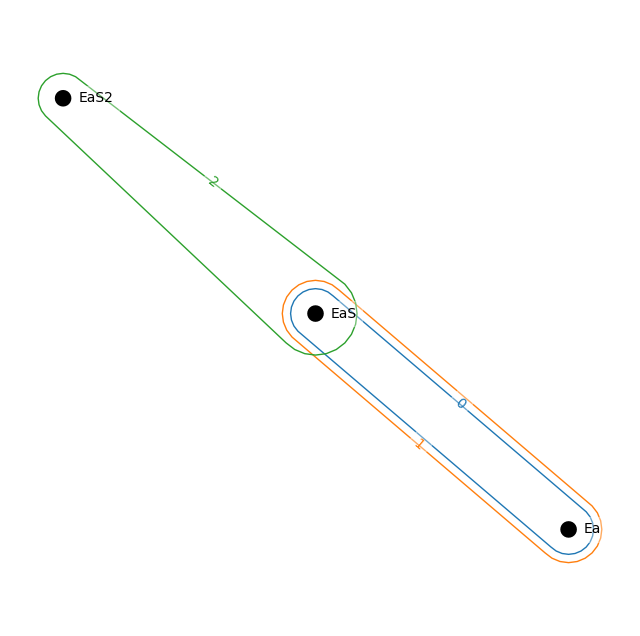

In [15]:
# incidence matrix for the inner part of the top circuit
# the rows are the verrtices and the columns are the hyperdges
# if an element ij is nonzero, then the vertex i is in the hyperdge j

#  here the row
# 0 -> Ea
# 1 -> EaS
# 2 -> EaS2
#  
# while the column
# 0 -> reaction 1
# 1 -> reaction 2
# 2 -> reaction3


inner_1 = np.array([
    [-1,1,0],
    [1,-1,-1],
    [0,0,1]

])
node_labels = {0:'Ea', 1:'EaS', 2:'EaS2'}
H = hnx.Hypergraph.from_incidence_matrix(inner_1)

hnx.draw(H, node_labels = node_labels)

# print(H.dataframe)

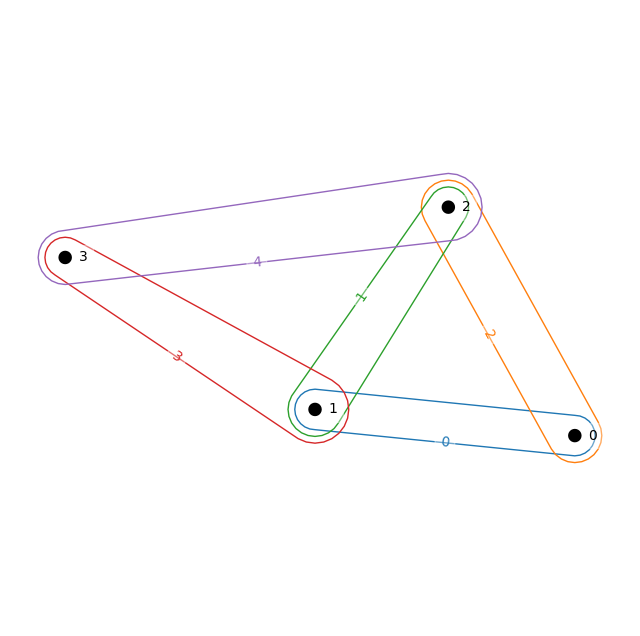

In [20]:
inner_2 = np.array([
[-1,0,1,0,0],
[1,-1,0,-1,0],
[0,1,-1,0,1],
[0,0,0,1,-1]
])
# node_labels = {0:'Ea', 1:'EaS', 2:'EaS2'}
H = hnx.Hypergraph.from_incidence_matrix(inner_2)

hnx.draw(H)# node_labels = node_labels)


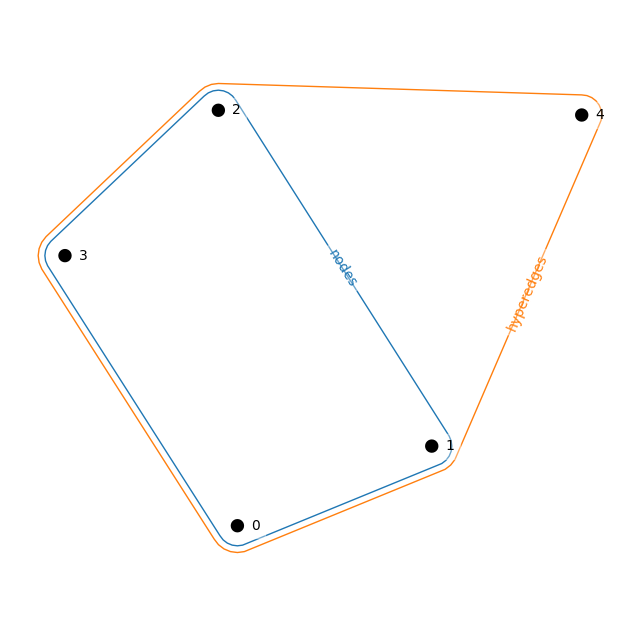

In [21]:
# biparitte visualisation

bipartite_data = {}

# Add nodes from original hypergraph as a set
bipartite_data['nodes'] = list(H.nodes)

# Add hyperedges as a set
bipartite_data['hyperedges'] = list(H.edges)

# Create the bipartite hypergraph
B = hnx.Hypergraph(bipartite_data)

# Visualize or process the bipartite hypergraph
hnx.draw(B)